In [3]:
import random
import math
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from scipy.stats import rv_continuous
from scipy.optimize import curve_fit
import time
import warnings
import sys
from itertools import accumulate as _accumulate, repeat as _repeat
from bisect import bisect as _bisect
from matplotlib.colors import ListedColormap, BoundaryNorm    
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def choices(population, weights=None, *, cum_weights=None, k=1):
    """Return a k sized list of population elements chosen with replacement.
    If the relative weights or cumulative weights are not specified,
    the selections are made with equal probability.
    """
    n = len(population)
    if cum_weights is None:
        if weights is None:
            _int = int
            n += 0.0    # convert to float for a small speed improvement
            return [population[_int(random.random() * n)] for i in _repeat(None, k)]
        cum_weights = list(_accumulate(weights))
    elif weights is not None:
        raise TypeError('Cannot specify both weights and cumulative weights')
    if len(cum_weights) != n:
        raise ValueError('The number of weights does not match the population')
    bisect = _bisect
    total = cum_weights[-1] + 0.0   # convert to float
    hi = n - 1
    return [population[bisect(cum_weights, random.random() * total, 0, hi)]
            for i in _repeat(None, k)]


class exponential(rv_continuous):
    '''
    This is a VERY confusing part of the code. This is supposed to create a custom
    probability distribution function, equation 3 in the article. This is what is
    (apparently) called an abstract base class (ABC), its kind of a base class where
    you can build the "rest" of the class by yourself. In this case, we give this class
    a distribution function, and the class takes care of making it work with every
    other function and class in the module and in python. Here is the link for the class:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html
    '''
    def _pdf(self, x, eta, w0):

        return eta*math.exp(-(x/w0)**eta)/(w0*math.gamma(1/eta))

stretched_exponential=exponential(name='stretched_exponential', a=0)

class alpha_G_prob(rv_continuous):

    def _pdf(self, x, alpha_G, d):

        return (d+alpha_G-1)*(1/x**(d+alpha_G))

alpha_dist=alpha_G_prob(name='alpha_dist', a=1)


In [3]:
class Quark:

    '''
    For some algorithms, we will need networks that take into account the euclidean
    positions and distances between the nodes, which is not (to my knowledge)
    supported by networkx, so this class and the Geo_Network class will be created
    in order to create such networks. The present class will be used for each
    individual node.
    '''

    def __init__(self, position, label, weight = 1, flavor = 'particle'):
        '''
        The position has to be any 2 valued (x,y) set (a tuple, a list, whatever)
        containing the x and y component of the position of the node. Maybe
        in the future I can work with z components. The weight of the node
        is set to 1 (in case your network in unweighted), otherwise you can
        set a weight yourself.
        '''

        self.label=label #every node has a label to distinguish it from the others,
        #it can be a number for example.

        self.x = position[0]
        self.y = position[1]
        self.z = position[2]
        self.position = (self.x, self.y, self.z)
        self.px = 0 
        self.py = 0
        self.pz = 0
        self.momentum = (self.px, self.py, self.pz)
        self.connections=[]
        '''self.flavor = choices(['up', 'down', 'top', 'bottom', 'charm', 'strange',
                'antiup', 'antidown', 'antitop', 'antibottom', 'anticharm', 'antistrange'])


        if self.flavor == ['up']:
          self.charge = 2/3*1E-9 #in GeV
          self.mass = 3E-3 #in GeV/c^2

        elif self.flavor == ['down']:
          self.charge = -1/3*1E-9 #in GeV
          self.mass = 6E-3 #in GeV/c^2

        elif self.flavor == ['top']:
          self.charge = 2/3*1E-9 #in GeV
          self.mass = 174 #in GeV/c^2

        elif self.flavor == ['bottom']:
          self.charge = -1/3*1E-9 #in GeV
          self.mass = 4.5 #in GeV/c^2

        elif self.flavor == ['charm']:
          self.charge = 2/3*1E-9 #in GeV
          self.mass = 1.3 #in GeV/c^2

        elif self.flavor == ['strange']:
          self.charge = -1/3*1E-9 #in GeV
          self.mass = 8E-2 #in GeV/c^2

        elif self.flavor == ['antiup']:
          self.charge = -2/3*1E-9 #in GeV
          self.mass = 3E-3 #in GeV/c^2

        elif self.flavor == ['antidown']:
          self.charge = 1/3*1E-9 #in GeV
          self.mass = 6E-3 #in GeV/c^2

        elif self.flavor == ['antitop']:
          self.charge = -2/3*1E-9 #in GeV
          self.mass = 174 #in GeV/c^2

        elif self.flavor == ['antibottom']:
          self.charge = 1/3*1E-9 #in GeV
          self.mass = 4.5 #in GeV/c^2

        elif self.flavor == ['anticharm']:
          self.charge = -2/3*1E-9 #in GeV
          self.mass = 1.3 #in GeV/c^2

        elif self.flavor == ['antistrange']:
          self.charge = 1/3*1E-9 #in GeV
          self.mass = 8E-2 #in GeV/c^2'''

        self.flavor = [flavor]

        if self.flavor == ['particle']:
          #self.charge = 1*1E-9 #in GeV
          self.charge = 1*1E-5
          self.mass = 1 #in GeV/c^2'''
          self.plotcolor = 'blue'

        elif self.flavor == ['antiparticle']:
          #self.charge = -1*1E-9 #in GeV
          self.charge = -1*1E-5
          self.mass = 1 #in GeV/c^2'''
          self.plotcolor = 'grey'

        self.energy= np.sqrt((self.mass)**2 + (self.px**2) + (self.py**2) + (self.pz**2))
        '''self.color = color'''

        
        self.change_direction = 'No'  #This property is responsable for the process of the quark to interact with the wall
        #in the dynamical evolution of the position of the particle, if its hits the wall, this property should be
        #modified to 'Yes' and its connections have to as well, so it will certify that the meson/hadron will not lose its vibration internal structure 


    def update_position(self, position):
      self.x = position[0]
      self.y = position[1]
      self.z = position[2]
      self.position = (self.x, self.y, self.z)

    def update_momentum(self, momentum):
      self.px = momentum[0]
      self.py = momentum[1]
      self.pz = momentum[2]
      self.momentum = (self.px, self.py, self.pz)
      self.update_energy()

    #def update_energy(self, edge_dict):
    def update_energy(self):
        #the edge_dict has to be the dictionary of edges available with the
        #Geo_Network class.

        self.energy = np.sqrt((self.mass)**2 + (self.px**2) + (self.py**2) + (self.pz**2))
        '''new_energy=0
        for edge in edge_dict:
            if self in edge:
                new_energy+=edge_dict[edge]/2
        self.energy = new_energy'''

In [ ]:
class QGP_System:
    '''
    Read the Geo_Nodes class description first. This class will store the network
    itself of that kind of network, and will have functions that concern the whole
    network.
    '''

    def __init__(self,d, edges_list=None):
        '''
        The network starts completely empty if you don't initiate it with any
        arguments, and then you can build the network yourself. If, on the other
        hand, you have a pre-made network and want to use it, you can do it, the
        edges_list argument receives a list on the format [(A,B,w1), (A,C,w2), (B,D,w3), etc]
        containing all the edges of the network, where A, B, C, D, etc, are nodes
        (Geo_Node format) of your network and (A,B,w) represents an edge between
        nodes A and B with weight w.
        '''
        if edges_list!=None:

            self.edges=[(edge[0], edge[1]) for edge in edges_list]
            self.quarks=[]
            self.edges_weights={} #dict storing the weights of the edges

            for edge in edges_list:
                if len(edge)==3:
                    self.edges_weights[edge]=edge[2]

            for tup in self.edges:

                if tup[0] not in self.quarks:
                    self.quarks.append(tup[0])

                if tup[1] not in self.quarks:
                    self.quarks.append(tup[1])


            xsum=0
            ysum=0
            zsum=0
            weight_sum=0

            for quark in self.quarks:
                xsum+=quark.energy*quark.x
                ysum+=quark.energy*quark.y
                zsum+=quark.energy*quark.z
                weight_sum+=quark.energy

            self.center_mass=(xsum/weight_sum, ysum/weight_sum, zsum/weight_sum)

        else:
            self.quarks=[]
            self.edges=[]
            self.center_mass=None
            self.edges_weights={}

    def add_quark(self, quark): #node has to be an object of the type Quark

        self.quarks.append(quark)

    def add_edge(self, quark1, quark2, weight):
        '''
        This function can create an edge between two preexisting nodes, or you
        can create new nodes from it. If you do self.add_edge(A,B), both A and
        B still not in the network, they will automatically be put in the network,
        along with the edge between them. node1 and node2 obviously have to be
        of the class Geo_Node.
        '''
        self.edges_weights[(quark1, quark2)]=weight

        if (quark1, quark2) not in self.edges:
            self.edges.append((quark1, quark2))

        if quark1 not in self.quarks:
            self.quarks.append(quark1)

        if quark2 not in self.quarks:
            self.quarks.append(quark2)

    def euclid_distance(self, quark1, quark2):
        #calculate the euclidean distance between node1 and node2
        distance= ((quark1.x-quark2.x)**2+(quark1.y-quark2.y)**2+(quark1.z-quark2.z)**2)**0.5

        return distance

    def update_center(self):
        #update the center of mass of the network


        xsum=0
        ysum=0
        zsum=0
        weight_sum=0

        for quark in self.quarks:
            xsum+=quark.energy*quark.x
            ysum+=quark.energy*quark.y
            zsum+=quark.energy*quark.z
            weight_sum+=quark.energy

        self.center_mass=(xsum/weight_sum, ysum/weight_sum, zsum/weight_sum)


: 

In [ ]:
def TN_model_generate(N, d, eta, w0, alpha_A, alpha_G, index):

    '''
    This function will create a network based on a network model presented by
    Constantino Tsallis in the paper available in the references text. The model
    is still unamed, so I named it for the purposes of this code as Tsallis Network
    model (explaining why TN_model). The parameters alpha are, obviously, the same
    alphas from the article used as reference and N is the number of iterations.
    The dimension, for now, will be always 2 for simplicity.
    '''
    nk=QGP_System(d)

    quark1=Quark((0,0,0), 1)
    nk.add_quark(quark1)
    nk.update_center()
    quark1.update_energy()


    for i in range(1,N):
      r=alpha_dist.rvs(alpha_G, d)
      u=random.uniform(0,1)
      v=random.uniform(0,1)
      theta= 2*np.pi*u
      phi=np.arccos(1-2*v)
      quarki_x=nk.center_mass[0]+r*np.cos(theta)*np.sin(phi)
      quarki_y=nk.center_mass[1]+r*np.sin(theta)*np.sin(phi)
      quarki_z=nk.center_mass[2]+r*np.cos(phi)
      quarki=Quark((quarki_x, quarki_y, quarki_z),i+1)
      nk.add_quark(quarki)
      nk.update_center()
      #print('Iteration', i+1, 'is complete!')

    nksize = len(nk.quarks)
    for i in range (nksize):
      meson_radius = 5E-6 #in GeV^-1
      r = meson_radius* np.random.normal()
      #print(r)
      u = random.uniform(0,1)
      v = random.uniform(0,1)
      theta = 2*np.pi*u
      phi = np.arccos(1-2*v)
      antiquarki_x = nk.quarks[i].x  + r*np.cos(theta)*np.sin(phi)
      antiquarki_y = nk.quarks[i].y + r*np.sin(theta)*np.sin(phi)
      antiquarki_z = nk.quarks[i].z + r*np.cos(phi)
      antiquarki = Quark((antiquarki_x, antiquarki_y, antiquarki_z),nksize + i + 1, 1, 'antiparticle')
      nk.add_quark(antiquarki)
      edgeij_weight= stretched_exponential.rvs(eta, w0)
      nk.add_edge(nk.quarks[i], antiquarki, edgeij_weight)
      nk.quarks[i].connections.append(antiquarki.label)
      antiquarki.connections.append(nk.quarks[i].label)
      nk.quarks[i].update_energy()
      antiquarki.update_energy()

    nk.update_center()
    return nk

: 

In [ ]:
def print_Geo_Network(nk, title='My Network', save = False, j = 0):
    '''
    This function takes as an argument an object of the class Geo_Network, and
    it prints, using matplotlib, the network with simple lines representing edges
    and dots representing nodes. In the future, I'll try to work out a way to
    display the weight of the nodes and edges using different sizes and/or colors.
    You can set the title of the network with the title argument. If save is set
    to True, it will save a .png image of the network on the same directory as
    your code.
    '''

    box_radius = 1
    x_list, y_list, z_list = [],[],[]
    plotcolor = []
    for quark in nk.quarks:
      x_list.append(quark.x)
      y_list.append(quark.y)
      z_list.append(quark.z)
      lines = [[edges[0].position, edges[1].position] for edges in rede.edges]
      plotcolor.append(quark.plotcolor)
    #lc = mc.LineCollection(lines, colors='black', linewidths=0.5)
    lc = Line3DCollection(lines, cmap=plt.get_cmap('copper'))
    lc.set_linewidth(0.3)
    #path = r"E:\Downloads\Print"
    #os.chdir(path)

    fig = plt.figure(dpi= 500)
    #ax = plt.figure(dpi=300)



    ax = fig.add_subplot(1,1,1, projection = '3d')
    #ax = plt.axes(projection='3d')
    ax.add_collection3d(lc, )
    ax.scatter3D(x_list, y_list, z_list, color = plotcolor, cmap= 'green');
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('QGP Test')
    #ax.set_xlim(-box_radius,box_radius)
    #ax.set_ylim(-box_radius,box_radius)
    #ax.set_zlim(-box_radius,box_radius)

    ax = fig.add_subplot(2,1,1)
    
    plt.show()

    if save==True:
        plt.savefig('%d.jpg' %(j), dpi = 500)

: 

In [ ]:
N = 1
#amostras = 1
d = 3
aA = 2.00
aG = 1
w0 = 1
eta = 1.00
Temperature  = 1e-1
rede = TN_model_generate(N, d, eta, w0,  aA, aG, 0)
print_Geo_Network(rede)

: 

In [ ]:
def dH_dpx(quark):
  m = quark.mass #mass of quark, need to be modifying later 
  return quark.momentum[0]/m

def dH_dpy(quark):
  m = quark.mass #mass of quark, need to be modifying later 
  return quark.momentum[1]/m

def dH_dpz(quark):
  m = quark.mass #mass of quark, need to be modifying later 
  return quark.momentum[2]/m

def dH_dx(quark, nk):
  #Quark Quark Potential
  '''F_qq = 0
  for connection in quark.connections:
      r = nk.euclid_distance(quark, nk.quarks[connection - 1])
      F_qq = F_qq - (quark.x - nk.quarks[connection - 1].x)/(r**3)'''

  '''#Potential test
  F_test = 0
  A = 1
  B = -A
  for connection in quark.connections:
    r = nk.euclid_distance(quark, nk.quarks[connection - 1])
    F_test = F_test + ((A/r) + (B/r**2))*(quark.x - nk.quarks[connection - 1].x)'''

  #Harmonic Potential
  F_spring = 0
  l = 5E-8 #in GeV^-1
  for connection in quark.connections:
    r = (quark.x - nk.quarks[connection - 1].x ) 
    F_spring = F_spring + r #- l*math.copysign(1, l)
  
  F = F_spring
  #F = F_test

  return F


def dH_dy(quark, nk):
  #Harmonic Potential
  F_spring = 0
  l = 5E-8 #in GeV^-1
  for connection in quark.connections:
    r = (quark.y - nk.quarks[connection - 1].y) 
    F_spring = F_spring + r #- l*math.copysign(1, l)

  #Potential test
  '''F_test = 0
  A = 1
  B = -A
  for connection in quark.connections:
    r = nk.euclid_distance(quark, nk.quarks[connection - 1])
    F_test = F_test + ((A/r) + (B/r**2))*(quark.y - nk.quarks[connection - 1].y)'''
  
  F = F_spring
  #F = F_test

  return F


def dH_dz(quark, nk):
  #Harmonic Potential
  F_spring = 0
  l = 5E-8 #in GeV^-1
  for connection in quark.connections:
    r = (quark.z - nk.quarks[connection - 1].z)
    F_spring = F_spring + r #- l*math.copysign(1, l)

  #Potential test
  '''F_test = 0
  A = 1
  B = -A
  for connection in quark.connections:
    r = nk.euclid_distance(quark, nk.quarks[connection - 1])
    F_test = F_test + ((A/r) + (B/r**2))*(quark.z - nk.quarks[connection - 1].z)'''

  F = F_spring
  #F = F_test

  return F


def simulation(nk, Temperature, d, tf, dt, frame):
  box_radius = 1

  #Setting initial momentums 
  for i in range (len(nk.quarks)):
    quark_kinect_energy = Temperature*np.random.randn()
    print('estou aqui')
    print(quark_kinect_energy)
    u=random.uniform(0,1)
    v=random.uniform(0,1)
    theta= 2*np.pi*u
    phi=np.arccos(1-2*v)
    quarki_px0=quark_kinect_energy*np.cos(theta)*np.sin(phi)
    quarki_py0=quark_kinect_energy*np.sin(theta)*np.sin(phi)
    quarki_pz0=quark_kinect_energy*np.cos(phi)
    nk.quarks[i].update_momentum((quarki_px0, quarki_py0, quarki_pz0))
    #nk.quarks[i].update_momentum((0, 0, 0))

  t = np.linspace(0,tf, int(tf/dt))
  distance = np.zeros(len(t))
  energy1 = np.zeros(len(t))
  energy2 = np.zeros(len(t))
  total_energy = np.zeros(len(t))
  for j in range (len(t)-1):
    position = np.zeros((len(nk.quarks),3))
    momentum = np.zeros((len(nk.quarks),3))
    for i in range (len(nk.quarks)):    
      x_t = nk.quarks[i].x
      y_t = nk.quarks[i].y
      z_t = nk.quarks[i].z
      position[i][0] = x_t + (t[j+1] - t[j]) * dH_dpx(nk.quarks[i])
      position[i][1] = y_t + (t[j+1] - t[j]) * dH_dpy(nk.quarks[i])
      position[i][2] = z_t + (t[j+1] - t[j]) * dH_dpz(nk.quarks[i])
    for i in range (len(nk.quarks)):
     nk.quarks[i].update_position((position[i][0], position[i][1], position[i][2]))
    for i in range (len(nk.quarks)): 
      px_t = nk.quarks[i].px
      py_t = nk.quarks[i].py
      pz_t = nk.quarks[i].pz
      momentum[i][0] = px_t - (t[j+1] - t[j]) * dH_dx(nk.quarks[i], nk)
      momentum[i][1] = py_t - (t[j+1] - t[j]) * dH_dy(nk.quarks[i], nk)
      momentum[i][2] = pz_t - (t[j+1] - t[j]) * dH_dz(nk.quarks[i], nk)
    '''for i in range (len(nk.quarks)):
      nk.quarks[i].update_momentum((momentum[i][0], momentum[i][1], momentum[i][2]))'''
    for i in range (len(nk.quarks)):
      if position[i][0] > box_radius or position[i][0] < -box_radius:
        momentum[i][0] = -momentum[i][0]
        '''for connection in nk.quarks[i].connections:
          momentum[connection - 1][0] = -momentum[connection - 1][0]'''
      if position[i][1] > box_radius or position[i][1] < -box_radius:
        momentum[i][1] = -momentum[i][1]
        '''for connection in nk.quarks[i].connections:
          momentum[connection - 1][1] = -momentum[connection - 1][1]'''
      if position[i][2] > box_radius or position[i][2] < -box_radius:
        momentum[i][2] = -momentum[i][2]
        '''for connection in nk.quarks[i].connections:
          momentum[connection - 1][2] = -momentum[connection - 1][2]'''
      nk.quarks[i].update_momentum((momentum[i][0], momentum[i][1], momentum[i][2]))
      '''for connection in nk.quarks[i].connections:
        nk.quarks[connection - 1].update_momentum((momentum[connection - 1][0], momentum[connection - 1][1], momentum[connection - 1][2]))'''

    nk.update_center()
    distance[j] = nk.euclid_distance(nk.quarks[0], nk.quarks[N])
    energy1[j] = nk.quarks[0].energy
    energy2[j] = nk.quarks[N].energy
    total_energy[j] = nk.quarks[0].energy + nk.quarks[N].energy
    #if j% frame == 0:
      #print(j)
      #print_Geo_Network(nk, 'QGP Simulation', False, j)
      #print_Geo_Network(nk)
      #print(nk.quarks[len(nk.quarks)-1].position)
      #print(nk.euclid_distance(nk.quarks[0], nk.quarks[1]))
      



  return distance, t, energy1, energy2, total_energy


: 

Implementação Runge Kutta

In [2]:

def Runge_Kutta4_position(p_t, dt):
  




def simulation_RK4(nk, d, tf, dt, frame):

  #Setting initial momentums 
  for i in range (len(nk.quarks)):
    u=random.uniform(0,1)
    v=random.uniform(0,1)
    theta= 2*np.pi*u
    phi=np.arccos(1-2*v)
    quarki_px0=nk.quarks[i].energy*np.cos(theta)*np.sin(phi)
    quarki_py0=nk.quarks[i].energy*np.sin(theta)*np.sin(phi)
    quarki_pz0=nk.quarks[i].energy*np.cos(phi)
    nk.quarks[i].update_momentum((quarki_px0, quarki_py0, quarki_pz0))
    nk.quarks[i].update_momentum((0, 0, 0))

  t = np.linspace(0,tf, int(tf/dt))
  distance = np.zeros(len(t))
  energy1 = np.zeros(len(t))
  energy2 = np.zeros(len(t))
  total_energy = np.zeros(len(t))
  for j in range (len(t)-1):
    position = np.zeros((len(nk.quarks),3))
    momentum = np.zeros((len(nk.quarks),3))
    for i in range (len(nk.quarks)):    
      x_t = nk.quarks[i].x
      y_t = nk.quarks[i].y
      z_t = nk.quarks[i].z
      #print(dH_dx(nk.quarks[i], nk))
      dt = (t[j+1] - t[j])
      position[i][0] = x_t + dt * Runge_Kutta4_position(px_t , dt)
      position[i][1] = y_t + dt * Runge_Kutta4_position(py_t , dt)
      position[i][2] = z_t + dt * Runge_Kutta4_position(pz_t , dt)
    for i in range (len(nk.quarks)):
     nk.quarks[i].update_position((position[i][0], position[i][1], position[i][2]))
    for i in range (len(nk.quarks)): 
      px_t = nk.quarks[i].px
      py_t = nk.quarks[i].py
      pz_t = nk.quarks[i].pz
      momentum[i][0] = px_t - (t[i+1] - t[i]) * dH_dx(nk.quarks[i], nk)
      momentum[i][1] = py_t - (t[i+1] - t[i]) * dH_dy(nk.quarks[i], nk)
      momentum[i][2] = pz_t - (t[i+1] - t[i]) * dH_dz(nk.quarks[i], nk)
    for i in range (len(nk.quarks)):
      #nk.quarks[i].update_position((position[i][0], position[i][1], position[i][2]))
      nk.quarks[i].update_momentum((momentum[i][0], momentum[i][1], momentum[i][2]))
    nk.update_center()
    distance[j] = nk.euclid_distance(nk.quarks[0], nk.quarks[N])
    energy1[j] = nk.quarks[0].energy
    energy2[j] = nk.quarks[N].energy
    total_energy[j] = nk.quarks[0].energy + nk.quarks[N].energy
    if j% frame == 0:
      print(j)
      print_Geo_Network(nk, 'QGP Simulation', False, j)
      #print_Geo_Network(nk)
      #print(nk.quarks[len(nk.quarks)-1].position)
      #print(nk.euclid_distance(nk.quarks[0], nk.quarks[1]))
      



  return distance, t, energy1, energy2, total_energy

IndentationError: expected an indented block after function definition on line 1 (3332143013.py, line 7)

In [ ]:
'''l = 5E-6 #in GeV^-1
quark1 = Quark((0,0,0),1)
quark2 = Quark((l,l,l),2, 'antiparticle')
LIGA = [(quark1, quark2, 1)]
rede = QGP_System(3, LIGA)'''

N = 1
#amostras = 1
d = 3
aA = 2.00
aG = 1
w0 = 1
eta = 1.00
Temperature  = 1e-1
rede = TN_model_generate(N, d, eta, w0,  aA, aG, 0)
#print_Geo_Network(rede)
distance, time, energy1, energy2, total_energy = simulation(rede, Temperature, 3, 100, 1e-3, 5000)
time = time[:-1]
distance = distance[:-1]
energy1 = energy1[:-1]
energy2 = energy2[:-1]
total_energy = total_energy[:-1]
fig = plt.figure(dpi = 200)
plt.plot(time, distance, c = 'red', lw = 0.7 )
#plt.plot(time, energy1, c = 'red')
#plt.plot(time, energy2, c = 'blue')
#plt.plot(time, total_energy, c = 'black')


plt.xlabel(r'$t$ (in $GeV^{-1}$)')
plt.ylabel(r'$\Delta r$ (in $GeV^{-1}$)')
#plt.ylim(-1E-2, 1E-2)
plt.grid()
plt.title(r"$\Delta r \times   t$")
fig.show()

fig = plt.figure(dpi = 200)
#plt.plot(time, distance, c = 'red', lw = 0.7 )
plt.plot(time, total_energy)
plt.plot(time, energy1, c= 'blue')
plt.plot(time, energy2, c= 'yellow')
plt.xlabel(r'$t$ (in $GeV^{-1}$)')
plt.ylabel(r'Energy $GeV$)')
#plt.xlim(0,1000)
#plt.ylim(2.49E-6, 2.50E-6)
plt.grid()
#plt.grid(True, 'major', color='k')
#plt.minorticks_on()
#plt.grid(True, 'minor', 'y')
#plt.title(r"$\Delta r \times   t$")
#fig.show()

: 

In [9]:
print(distance)

[0.00017025 0.00034036 0.00051048 ... 0.10802695 0.10803973 0.10805252]


C:\Users\caiqu\AppData\Local\Temp\ipykernel_11912\2055844132.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


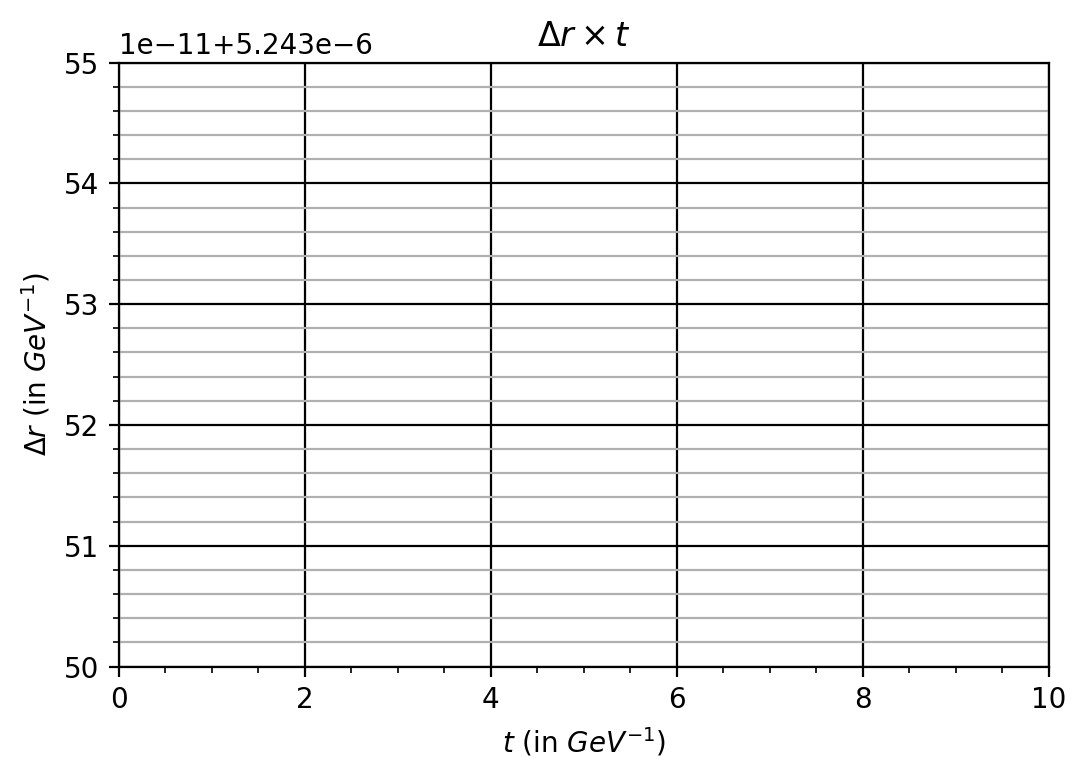

In [10]:

fig = plt.figure(dpi = 200)
plt.plot(time, distance, c = 'red', lw = 0.7 )
#plt.plot(time, total_energy)


plt.xlabel(r'$t$ (in $GeV^{-1}$)')
plt.ylabel(r'$\Delta r$ (in $GeV^{-1}$)')
plt.xlim(0,10)
plt.ylim(5.2435e-6, 5.24355e-6)

plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')
plt.title(r"$\Delta r \times   t$")
fig.show()

C:\Users\caiqu\AppData\Local\Temp\ipykernel_11912\3153219378.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


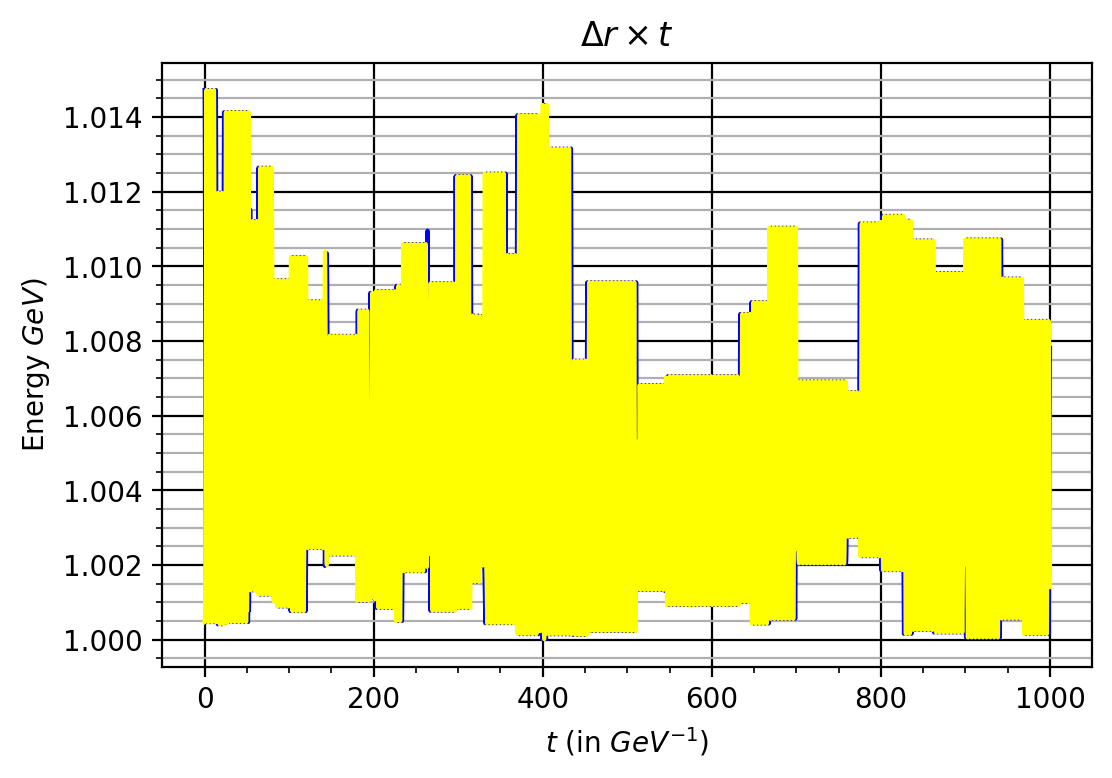

In [11]:

fig = plt.figure(dpi = 200)
#plt.plot(time, distance, c = 'red', lw = 0.7 )
#plt.plot(time, total_energy)
plt.plot(time, energy1, c= 'blue')
plt.plot(time, energy2, c= 'yellow')
plt.xlabel(r'$t$ (in $GeV^{-1}$)')
plt.ylabel(r'Energy $GeV$)')
#plt.xlim(0,1000)
#plt.ylim(999.9999999999999, 1000.000000000001)

plt.grid(True, 'major', color='k')
plt.minorticks_on()
plt.grid(True, 'minor', 'y')
plt.title(r"$\Delta r \times   t$")
fig.show()

In [12]:
N = 1
amostras = 1
d = 3
aA = 2.00
aG = 1
w0 = 1
eta = 1.00

rede = TN_model_generate(N, d, eta, w0,  aA, aG, 0)

fig = plt.figure(dpi = 200)

distance, time = simulation(rede, d, 100, 1e-3, 5000)
time = time[:-1]
distance = distance[:-1]
minimum = np.full(len(distance), np.amin(distance))
distance = distance - minimum
fig = plt.figure(dpi = 200)
plt.plot(time, distance, c = 'red', lw = 0.7 )



plt.xlabel(r'$t$ (in $GeV^{-1}$)')
plt.ylabel(r'$\Delta r$ (in $GeV^{-1}$)')

plt.grid()
plt.title(r"$\Delta \times   tr$")
fig.show()


TypeError: simulation() missing 1 required positional argument: 'frame'

<Figure size 1200x800 with 0 Axes>

In [ ]:
fig = plt.figure(dpi = 200)
plt.plot(time, distance, c = 'black', lw = 0.7 )



plt.xlabel('$t$ (in $GeV^{-1}$)')
plt.ylabel(r'$\Delta r$ (in $GeV^{-1}$)')
plt.ylim(-1, 5)
plt.grid()
plt.title(r"$\Delta r \times   t$ ")
fig.show()

: 


#EM DESENVOLVIMENTO

In [ ]:
class Gluon ():
  def __init__():
    self.x = 
    self.y =
    self.z = 
    self.position = 
    self.px =
    self.py =
    self.pz = 
    self.momentum = 
    self.energy = 
    self.connections = [] 


  def annihilation():
    #etc etc  

  def 
  


: 